# HUBERT

## Libraries

In [1]:
from datasets import Dataset, Audio, ClassLabel, Features, Value
import pandas as pd
import torch
import torch.nn as nn
import evaluate
import numpy as np
import warnings
from transformers import Trainer, TrainingArguments, TrainerCallback
from audiomentations import Compose, AddGaussianSNR, GainTransition, Gain, ClippingDistortion, TimeStretch, PitchShift
from transformers import AutoConfig, AutoModelForAudioClassification
from copy import deepcopy
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from collections import OrderedDict

2024-12-06 16:22:45.018867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733494965.043944 2442770 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733494965.050919 2442770 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 16:22:45.077540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Ensure GPU access

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f'Using device: {device}')

Using device: cuda


## Load dataset

In [3]:
# Define class labels
class_labels = ClassLabel(names=["Negative Sentiment", "Positive Sentiment"])

# Define features with audio and label columns
features = Features({
    "audio": Audio(),        # Define the audio feature
    "labels": class_labels,  # Assign the class labels
})

label2id = {
    "Negative Sentiment": 0,
    "Positive Sentiment": 1
}

In [4]:
dataset_base_path = "/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/"

In [5]:
# Load and preprocess the CSV file
df = pd.read_csv(dataset_base_path + "label_edited.csv", 
                 sep='\t', 
                 encoding='utf-8', 
                 header=0)

df = df[['video_id', 'clip_id', 'annotation_label', 'mode']].dropna()

In [6]:
# This function is used to return the full path of a video in the CMU-MOSI dataset format
def get_audio_path(video_id, clip_id):
    return dataset_base_path + f"Splited/Raw_onlyAudio/{video_id}/{clip_id}.wav"

#### Get audio paths and labels of the full dataset

In [7]:
# Construct audio file paths and labels
audio_paths = df.apply(lambda row: get_audio_path(row['video_id'], row['clip_id']), axis=1).tolist()
labels = df['annotation_label'].astype(int).tolist()  # Convert labels to integers if necessary

Assure they are loaded correctly

In [8]:
labels

[0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [9]:
audio_paths

['/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/Splited/Raw_onlyAudio/03bSnISJMiM/11.wav',
 '/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/Splited/Raw_onlyAudio/03bSnISJMiM/10.wav',
 '/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/Splited/Raw_onlyAudio/03bSnISJMiM/13.wav',
 '/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/Splited/Raw_onlyAudio/03bSnISJMiM/12.wav',
 '/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/Splited/Raw_onlyAudio/03bSnISJMiM/1.wav',
 '/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/Splited/Raw_onlyAudio/03bSnISJMiM/3.wav',
 '/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/Splited/Raw_onlyAudio/03bSnISJMiM/2.wav',
 '/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/Splited/Raw_onlyAudio/03bSnISJMiM/5.wav',
 '/home/k/kyparkypar

In [10]:
# dataset = Dataset.from_dict({
#     "audio": audio_paths,
#     "labels": labels,
# }, features=features)

In [11]:
# dataset

In [12]:
# # Verify the dataset structure
# print(dataset[0])

## Load feature extractor

In [13]:
from transformers import AutoFeatureExtractor
# we define which pretrained model we want to use and instantiate a feature extractor
pretrained_model = "superb/hubert-base-superb-er" # superb/hubert-base-superb-er: er - Emotion Recognition
                                                  # superb/hubert-base-superb-ks: ks - Keyword Spotting
feature_extractor = AutoFeatureExtractor.from_pretrained(pretrained_model,
                                                         return_attention_mask=True
                                                         )

# from transformers import Wav2Vec2FeatureExtractor
# # Load the feature extractor
# pretrained_model = "facebook/hubert-base-ls960"
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(pretrained_model,
#                                                              return_attention_mask=True,
#                                                             )

### View extractor's inputs

In [15]:
# we save model input name and sampling rate for later use
model_input_name = 'input_values'  # key -> 'input_values'
SAMPLING_RATE = feature_extractor.sampling_rate

In [16]:
feature_extractor.model_input_names

['input_values', 'attention_mask']

In [17]:
print(str(SAMPLING_RATE) + " Hz")

16000 Hz


### Set maximum audio length to be processed

- Below this value, the audio will be padded.
- After this value, the audio will be truncated

In [18]:
MAX_AUDIO_SECONDS = 10  # Maximum audio duration in seconds
MAX_AUDIO_LENGTH = SAMPLING_RATE * MAX_AUDIO_SECONDS

In [19]:
print(str(MAX_AUDIO_LENGTH) + " max samples length")

160000 max samples length


## Dataset Preprocess

In [20]:
def preprocess_audio(batch):
    wavs = [audio["array"] for audio in batch["input_values"]]
    
    # inputs are spectrograms as torch.tensors now
    inputs = feature_extractor(wavs, 
                               sampling_rate=SAMPLING_RATE,
                               max_length=MAX_AUDIO_LENGTH,
                               padding="max_length",
                               truncation=True,
                               return_tensors="pt")
    # print(inputs)
    output_batch = {"input_values": inputs.input_values, 
                    "attention_mask": inputs.attention_mask,
                    "labels": list(batch["labels"])
                   }
    
    return output_batch

### Augmentations

In [21]:
audio_augmentations = Compose([
#     Adds Gaussian noise to the audio while maintaining a specified signal-to-noise ratio (SNR)
    AddGaussianSNR(min_snr_db=10,    # min_snr_db: Minimum SNR in decibels (dB). A lower value means more noise.
                   max_snr_db=30),   # max_snr_db: Maximum SNR in dB. A higher value means less noise.
#     Adjusts the audio volume by applying a uniform gain
    Gain(min_gain_db=-6,      # min_gain_db: Minimum gain in dB. A negative value decreases volume.
         max_gain_db=6),      # max_gain_db: Maximum gain in dB. A positive value increases volume.
#     Gradually applies gain changes over a specified duration to create a smooth volume transition.
    GainTransition(min_gain_db=-6,                     # min_gain_db: Minimum gain change in dB. Negative for fading out, positive for fading in.
                   max_gain_db=6,                      # max_gain_db: Maximum gain change in dB.
                   min_duration=0.1,                   # min_duration: Minimum duration of the gain transition (in seconds or as a fraction of total duration, depending on duration_unit
                   max_duration=0.3,                   # max_duration: Maximum duration of the gain transition.
                   duration_unit="fraction"),          # "fraction": Durations are a fraction of the total audio length.
                                                       # "seconds": Durations are in absolute time.
#     Simulates distortion by artificially clipping the waveform
    ClippingDistortion(min_percentile_threshold=0,     # min_percentile_threshold: Minimum amplitude threshold percentile for clipping.
                       max_percentile_threshold=30,    # max_percentile_threshold: Maximum amplitude threshold percentile for clipping. A higher value clips more of the waveform.
                       p=0.5),                         # p: Probability of applying this augmentation.
#     Alters the playback speed of the audio without changing its pitch
    TimeStretch(min_rate=0.8,       # min_rate: Minimum playback speed (as a fraction of the original). Values <1 slow down the audio.
                max_rate=1.5),      # max_rate: Maximum playback speed. Values >1 speed up the audio.
#     Changes the pitch of the audio without altering its speed
    PitchShift(min_semitones=-4,    # min_semitones: Minimum pitch shift in semitones (negative values lower the pitch).
               max_semitones=4),    # max_semitones: Maximum pitch shift in semitones (positive values raise the pitch).
], p=0.8, shuffle=True)  # p: Overall probability of applying the composed augmentations
                         # shuffle: Randomly shuffles the order of augmentations during each application.

def preprocess_audio_with_transforms(batch):
    # we apply augmentations on each waveform
    wavs = [audio_augmentations(audio["array"], sample_rate=SAMPLING_RATE) for audio in batch["input_values"]]
    # inputs are spectrograms as torch.tensors now
    inputs = feature_extractor(wavs, 
                               sampling_rate=SAMPLING_RATE,
                               max_length=MAX_AUDIO_LENGTH,
                               padding="max_length",
                               truncation=True,
                               return_tensors="pt")
    # print(inputs)
    output_batch = {"input_values": inputs.input_values, 
                    "attention_mask": inputs.attention_mask,
                    "labels": list(batch["labels"])
                   }

    return output_batch

# # Cast the audio column to the appropriate feature type and rename it
# dataset = dataset.cast_column("audio", Audio(sampling_rate=feature_extractor.sampling_rate))
# dataset = dataset.rename_column("audio", "input_values")

In [22]:
# # Apply the transformation to the whole dataset (Train, Validation, Test)
# dataset = dataset.rename_column("audio", "input_values")  # rename audio column
# dataset.set_transform(preprocess_audio, output_all_columns=True)

### Dataset's split

Here we use the dataset's preset split, in order to compare we other models

In [23]:
train_df = df[df['mode'] == 'train']
valid_df = df[df['mode'] == 'valid']
test_df = df[df['mode'] == 'test']

In [24]:
def create_dataset_from_df(df):
    audio_paths = df.apply(lambda row: get_audio_path(row['video_id'], row['clip_id']), axis=1).tolist()
    labels = df['annotation_label'].astype(int).tolist()
    
    return Dataset.from_dict({
        "audio": audio_paths,
        "labels": labels,
    }, features=features)

In [25]:
train_dataset = create_dataset_from_df(train_df).rename_column("audio", "input_values")  # rename audio column

valid_dataset = create_dataset_from_df(valid_df).rename_column("audio", "input_values") 

test_dataset = create_dataset_from_df(test_df).rename_column("audio", "input_values")  

Assure how the dataset is saved

In [26]:
train_dataset

Dataset({
    features: ['input_values', 'labels'],
    num_rows: 1284
})

Create a unified dataset

In [27]:
# Create a dictionary to access datasets by their split names
dataset = {
    'train': train_dataset,
    'validation': valid_dataset,
    'test': test_dataset
}

Assurances again:

In [28]:
dataset

{'train': Dataset({
     features: ['input_values', 'labels'],
     num_rows: 1284
 }),
 'validation': Dataset({
     features: ['input_values', 'labels'],
     num_rows: 229
 }),
 'test': Dataset({
     features: ['input_values', 'labels'],
     num_rows: 686
 })}

In [29]:
train_dataset_size = len(dataset["train"])
validation_dataset_size = len(dataset["validation"]) 
test_dataset_size = len(dataset["validation"]) 

#### Dataset Normalization

Firstly, we set normalization to `False` in order to calculate the mean and std of the dataset.

In [30]:
feature_extractor.do_normalize = False 

In [31]:
# mean = []
# std = []
# # 
# train_dataset_copy = deepcopy(train_dataset)
# # we use the transformation w/o augmentation on the training dataset to calculate the mean + std
# train_dataset_copy.set_transform(preprocess_audio, 
#                                  output_all_columns=False)
# for i, (audio_input, labels) in enumerate(train_dataset_copy):
#     if i%100 == 0:
#         print(i)
#     cur_mean = torch.mean(train_dataset_copy[i][audio_input])
#     cur_std = torch.std(train_dataset_copy[i][audio_input])
#     mean.append(cur_mean)
#     std.append(cur_std)

# del train_dataset_copy

In [32]:
feature_extractor.mean = -7.9245896
feature_extractor.std = 5.2356324

In [33]:
print("Mean Value: ", feature_extractor.mean)

Mean Value:  -7.9245896


In [34]:
print("STD Value: ", feature_extractor.std)

STD Value:  5.2356324


Set the normalization to `True` back again

In [35]:
feature_extractor.do_normalize = True # we set normalization to true back again

More assurances:

In [36]:
dataset["train"]

Dataset({
    features: ['input_values', 'labels'],
    num_rows: 1284
})

In [37]:
dataset["train"][0]

{'input_values': {'path': '/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/Splited/Raw_onlyAudio/03bSnISJMiM/11.wav',
  'array': array([9.15527344e-05, 1.22070312e-04, 1.22070312e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
  'sampling_rate': 44100},
 'labels': 0}

In [38]:
# Cast the audio column to the appropriate feature type and rename it
dataset["train"] = dataset["train"].cast_column("input_values", Audio(sampling_rate=SAMPLING_RATE))
dataset["validation"] = dataset["validation"].cast_column("input_values", Audio(sampling_rate=SAMPLING_RATE))
dataset["test"] = dataset["test"].cast_column("input_values", Audio(sampling_rate=SAMPLING_RATE))

In [39]:
dataset["train"][0]

{'input_values': {'path': '/home/k/kyparkypar/ondemand/data/sys/myjobs/projects/default/dataset/CMU-MOSI/Splited/Raw_onlyAudio/03bSnISJMiM/11.wav',
  'array': array([ 7.19678137e-05,  1.10071793e-04,  7.78241883e-06, ...,
         -8.24081496e-08,  7.22105469e-08,  0.00000000e+00]),
  'sampling_rate': 16000},
 'labels': 0}

## Preprocess Dataset

### Transform Train set (w/ Augmentation ability)

In [40]:
dataset["train"].set_transform(preprocess_audio, 
                               output_all_columns=False)

# dataset["train"].set_transform(preprocess_audio_with_transforms, 
#                                output_all_columns=False)

### Transform Validation & Test set (No Augmentations)

In [41]:
# w/o augmentations on the validation & test set
dataset["validation"].set_transform(preprocess_audio, 
                                    output_all_columns=False)
dataset["test"].set_transform(preprocess_audio, 
                              output_all_columns=False)

##### Check dataset's labels and their names

In [42]:
# Check the actual labels corresponding to each label ID
labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [43]:
id2label

{'0': 'Negative Sentiment', '1': 'Positive Sentiment'}

### Compute class weights in train set

In [44]:
train_labels = np.asarray(train_df['annotation_label'].astype(int).tolist())

class_wts = compute_class_weight(class_weight='balanced',
                                 classes=np.unique(train_labels),
                                 y=train_labels)

In [45]:
class_wts

array([1.16304348, 0.87704918])

### Initialize base model

In [46]:
from transformers import HubertForSequenceClassification
from transformers import HubertConfig

# Load configuration from the pretrained model
config = HubertConfig.from_pretrained(pretrained_model)
# Update configuration with the number of labels in our dataset
config.num_labels = 2
config.label2id = label2id
config.id2label = {v: k for k, v in label2id.items()}

# Initialize the model with the updated configuration
model = HubertForSequenceClassification.from_pretrained(pretrained_model, 
                                                        config=config, 
                                                        ignore_mismatched_sizes=True)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
model.init_weights()

#### Check model architecture

In [48]:
model

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encod

In [49]:
model.hubert.encoder.layers[0].attention.q_proj.weight

Parameter containing:
tensor([[ 0.0006, -0.0193,  0.1099,  ...,  0.0835, -0.0670, -0.0027],
        [-0.0224, -0.0218, -0.0203,  ...,  0.0558, -0.0759,  0.1168],
        [ 0.0876, -0.0181, -0.0208,  ..., -0.0945, -0.0412,  0.0338],
        ...,
        [-0.0080, -0.0182,  0.0078,  ..., -0.0134, -0.0146,  0.0450],
        [-0.0313,  0.0047,  0.0078,  ...,  0.0442,  0.0608, -0.0986],
        [-0.0398, -0.0137, -0.0772,  ..., -0.0148,  0.0534,  0.0247]],
       requires_grad=True)

### Modify model's classifier head

##### Optimal parameters

In [50]:
hidden_size = 128         # [64, 32]
dropout_p = 0.3          # [0.1, 0.3]
act_func = 'tanh'        # [ReLU, TanH]

batch_size = 2           # GPU can only handle MAX batch_size=4 -> [2, 4]
grad_accum_steps = 8     # to simulate larger batch size -> [8, 4]

weight_decay = 1e-4      # [1e-4, 1e-5]
learning_rate = 1e-5     # Need smaller lrs -> [5e-5, 1e-5, 5e-6, 1e-6]

max_epochs = 4

In [51]:
if act_func == 'relu':
    activation_function = nn.ReLU()
elif act_func == 'tanh':
    activation_function = nn.Tanh()
elif act_func == 'No':
    activation_function = nn.Identity()

In [52]:
model.classifier = nn.Sequential(
    OrderedDict([
        ('dense', nn.Linear(256, hidden_size)),
        ('act_func', activation_function),
        ('dropout', nn.Dropout(dropout_p)),
        ('dense_outp', nn.Linear(hidden_size, model.config.num_labels)),
    ])
)

#### Check new model (w/ classifier head) architecture

In [53]:
model

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encod

In [54]:
model.hubert.encoder.layers[0].attention.q_proj.weight

Parameter containing:
tensor([[ 0.0006, -0.0193,  0.1099,  ...,  0.0835, -0.0670, -0.0027],
        [-0.0224, -0.0218, -0.0203,  ...,  0.0558, -0.0759,  0.1168],
        [ 0.0876, -0.0181, -0.0208,  ..., -0.0945, -0.0412,  0.0338],
        ...,
        [-0.0080, -0.0182,  0.0078,  ..., -0.0134, -0.0146,  0.0450],
        [-0.0313,  0.0047,  0.0078,  ...,  0.0442,  0.0608, -0.0986],
        [-0.0398, -0.0137, -0.0772,  ..., -0.0148,  0.0534,  0.0247]],
       requires_grad=True)

In [55]:
model.classifier.dense.weight

Parameter containing:
tensor([[-0.0223, -0.0278, -0.0551,  ...,  0.0559, -0.0297,  0.0347],
        [-0.0035,  0.0306, -0.0043,  ...,  0.0260, -0.0233,  0.0522],
        [-0.0001, -0.0568, -0.0146,  ...,  0.0439, -0.0197, -0.0617],
        ...,
        [ 0.0586, -0.0067,  0.0373,  ...,  0.0563,  0.0591, -0.0103],
        [-0.0311,  0.0233,  0.0493,  ...,  0.0229,  0.0251,  0.0450],
        [ 0.0298, -0.0062,  0.0501,  ...,  0.0092, -0.0564, -0.0491]],
       requires_grad=True)

##### Check if new model is trainable

In [56]:
for name, param in model.named_parameters():
        if 'hubert' or 'classifier' or 'pre_classifier' in name:
            print(f'{name}: {param.requires_grad}')

layer_weights: True
hubert.masked_spec_embed: True
hubert.feature_extractor.conv_layers.0.conv.weight: True
hubert.feature_extractor.conv_layers.0.layer_norm.weight: True
hubert.feature_extractor.conv_layers.0.layer_norm.bias: True
hubert.feature_extractor.conv_layers.1.conv.weight: True
hubert.feature_extractor.conv_layers.2.conv.weight: True
hubert.feature_extractor.conv_layers.3.conv.weight: True
hubert.feature_extractor.conv_layers.4.conv.weight: True
hubert.feature_extractor.conv_layers.5.conv.weight: True
hubert.feature_extractor.conv_layers.6.conv.weight: True
hubert.feature_projection.layer_norm.weight: True
hubert.feature_projection.layer_norm.bias: True
hubert.feature_projection.projection.weight: True
hubert.feature_projection.projection.bias: True
hubert.encoder.pos_conv_embed.conv.bias: True
hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0: True
hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1: True
hubert.encoder.layer_norm.weight: 

## Training

### Metrics calculation

In [57]:
## TODO: Fix metrics calculation

accuracy = evaluate.load("accuracy")
recall = evaluate.load("recall")
precision = evaluate.load("precision")
f1 = evaluate.load("f1")
AVERAGE = "binary"    # Default behavior for binary classification

def compute_metrics(eval_pred):   
    logits = eval_pred.predictions
    
    if isinstance(logits, tuple):
        logits = logits[0]
    #     print("--------------")
    #     print(logits)
    # else:
    #     print(logits)

    # Handle different shapes of logits
    if logits.ndim == 1:  # Binary classification or single-class scores
        predictions = (logits > 0).astype(int)  # Convert to binary predictions
    else:  # Multiclass classification
        predictions = np.argmax(logits, axis=1)
    
    metrics = {}
    metrics.update(accuracy.compute(predictions=predictions, references=eval_pred.label_ids))
    # metrics.update(precision.compute(predictions=predictions, references=eval_pred.label_ids, average=AVERAGE))
    # metrics.update(recall.compute(predictions=predictions, references=eval_pred.label_ids, average=AVERAGE))
    # metrics.update(f1.compute(predictions=predictions, references=eval_pred.label_ids, average=AVERAGE))
    # metrics['weighted_f1'] = f1.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")['f1']
    return metrics

In [58]:
# def preprocess_logits_for_metrics(logits, labels):
#     """
#     Original Trainer may have a memory leak. 
#     This is a workaround to avoid storing too many tensors that are not needed.
#     """
#     pred_ids = torch.argmax(logits[0], dim=-1)
#     return pred_ids, labels

### Training arguments

In [59]:
if max_epochs > 5:
    metric_for_best_model = "accuracy"
else:
    metric_for_best_model = "loss"

In [60]:
metric_for_best_model

'loss'

In [61]:
# Configure training run with TrainingArguments class
## TODO: See what happends with loss function
training_args = TrainingArguments(
    output_dir="./runs/hubert_classifier",
    logging_dir="./logs/hubert_classifier",
    report_to="tensorboard",
    learning_rate=learning_rate,                   
    push_to_hub=False,
    num_train_epochs=max_epochs,                   
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=grad_accum_steps,
    per_device_eval_batch_size=batch_size,
    eval_strategy="epoch",                       
    save_strategy="epoch",
    # eval_steps=1, 
    # save_steps=1,
    weight_decay=weight_decay,
    load_best_model_at_end=False,
    eval_accumulation_steps=8,
    # metric_for_best_model=metric_for_best_model,
    remove_unused_columns=False,
    logging_strategy="epoch",
    # logging_steps = (train_dataset_size // batch_size) // grad_accum_steps,
    lr_scheduler_type="constant",  # Ensures no decay in learning rate
    # fp16=True,
)

"Hack" the `Trainer` in order to insert:
- Class weights (since the train set is imbalanced)
- Assure that Cross Entropy is used as the loss function

In [62]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        
        outputs = model(
            input_values=inputs["input_values"],
            attention_mask=inputs.get("attention_mask"),
            labels=labels
        )
        # print(outputs)
        logits = outputs.get("logits")
        # print(logits)
        # Compute custom loss with class weights
        weights = torch.tensor(class_wts, dtype=torch.float).to(device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        # loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

Custom callback to track the best model's epoch

In [63]:
class BestModelEpochCallback(TrainerCallback):
    def __init__(self):
        self.best_loss = float("inf")
        self.best_acc = 0.0
        self.best_epoch = None
        self.training_metrics = []  # Track training loss at the end of each epoch
        self.eval_metrics = []      # Track evaluation loss at the end of each epoch
                        
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None and metric_for_best_model == "loss":
            if "eval_loss" in metrics:
                # print(state.epoch)
                # print(round(state.epoch))
                self.eval_metrics.append((round(state.epoch), metrics["eval_loss"]))
                current_loss = metrics["eval_loss"]
                # print(f"Epoch #{int(state.epoch)} | Validation Loss: {current_loss:.5f} | Validation Accuracy: {metrics['eval_accuracy']:.5f}")
                if current_loss < self.best_loss:
                    self.best_loss = current_loss
                    self.best_epoch = round(state.epoch)
                    self.best_acc = metrics["eval_accuracy"]
                    
        elif metrics is not None and metric_for_best_model == "accuracy":
            if "eval_loss" in metrics:
                self.eval_metrics.append((round(state.epoch), metrics["eval_loss"]))
                current_acc = metrics["eval_accuracy"]
                # print(f"Epoch #{int(state.epoch)} | Validation Accuracy: {metrics['eval_accuracy']:.5f} | Validation Loss: {current_loss:.5f}")
                if current_acc > self.best_acc:
                    self.best_acc = current_acc
                    self.best_epoch = round(state.epoch)
                    self.best_loss = metrics["eval_loss"]

    def on_epoch_end(self, args, state, control, **kwargs):
        # Log training loss at the end of the epoch
        if state.log_history:
            # Extract the last logged loss
            for log in reversed(state.log_history):
                if "loss" in log:
                    self.training_metrics.append((state.epoch, log["loss"]))
                    break

    # def on_log(self, args, state, control, logs=None, **kwargs):
    #     if logs and "loss" in logs:
    #         self.training_metrics.append((state.epoch, logs["loss"]))

best_model_callback = BestModelEpochCallback()

In [64]:
# Setup the trainer
trainer_new = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    callbacks=[best_model_callback],  # Not used during CV, only here to find optimal epochs
    compute_metrics=compute_metrics,  # Use the metrics function from above
    # preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)

In [65]:
warnings.filterwarnings("ignore", category=UserWarning, message=".*Converting to np.float32.*")
warnings.filterwarnings("ignore", message=".*is ill-defined.*")

In [66]:
trainer_new.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.686500,0.676550,0.598253
1,0.673300,0.693077,0.506550
2,0.649200,0.704735,0.554585
3,0.623100,0.676475,0.550218


TrainOutput(global_step=320, training_loss=0.6580420970916748, metrics={'train_runtime': 451.5603, 'train_samples_per_second': 11.374, 'train_steps_per_second': 0.709, 'total_flos': 4.649864871936e+17, 'train_loss': 0.6580420970916748, 'epoch': 3.987538940809969})

In [67]:
model.hubert.encoder.layers[0].attention.q_proj.weight

Parameter containing:
tensor([[ 0.0010, -0.0192,  0.1095,  ...,  0.0831, -0.0667, -0.0027],
        [-0.0223, -0.0217, -0.0208,  ...,  0.0565, -0.0760,  0.1171],
        [ 0.0880, -0.0180, -0.0202,  ..., -0.0944, -0.0415,  0.0335],
        ...,
        [-0.0081, -0.0177,  0.0072,  ..., -0.0132, -0.0145,  0.0455],
        [-0.0317,  0.0048,  0.0080,  ...,  0.0441,  0.0610, -0.0985],
        [-0.0399, -0.0135, -0.0770,  ..., -0.0146,  0.0530,  0.0245]],
       device='cuda:0', requires_grad=True)

In [68]:
model.classifier.dense.weight

Parameter containing:
tensor([[-0.0226, -0.0276, -0.0543,  ...,  0.0564, -0.0299,  0.0353],
        [-0.0032,  0.0303, -0.0052,  ...,  0.0256, -0.0231,  0.0516],
        [-0.0004, -0.0565, -0.0138,  ...,  0.0441, -0.0199, -0.0611],
        ...,
        [ 0.0583, -0.0064,  0.0382,  ...,  0.0568,  0.0590, -0.0096],
        [-0.0313,  0.0236,  0.0502,  ...,  0.0233,  0.0251,  0.0458],
        [ 0.0295, -0.0060,  0.0510,  ...,  0.0096, -0.0566, -0.0484]],
       device='cuda:0', requires_grad=True)

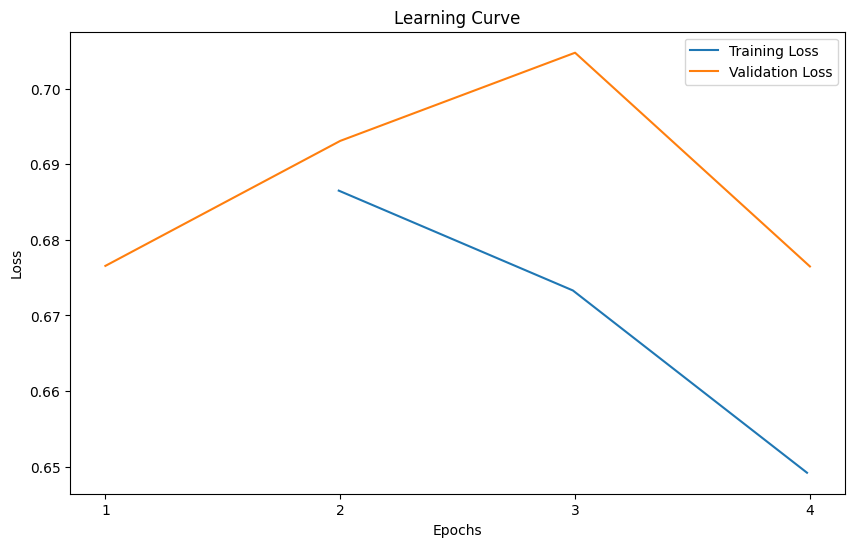

In [69]:
# Extract metrics
epochs, training_losses = zip(*best_model_callback.training_metrics)
eval_epochs, eval_losses = zip(*best_model_callback.eval_metrics)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, 
         label="Training Loss")
plt.plot(eval_epochs, eval_losses, 
         label="Validation Loss")
plt.xlabel("Epochs")
plt.xticks(range(1, max_epochs+1))
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()

# Show the plot
plt.show()

### Optimal epochs

In [70]:
# print("Optimal Epochs: ", int(best_model_callback.best_epoch))
print("Optimal Epochs: ", (int(best_model_callback.best_epoch)))

Optimal Epochs:  4


In [71]:
torch.cuda.empty_cache
gc.collect()

3410

## Metrics

### Inference

In [72]:
test_args = TrainingArguments(
    output_dir="./runs/hubert_classifier",
    report_to="tensorboard",
    do_train=False,
    do_predict=True,
    per_device_eval_batch_size=1,   
    eval_accumulation_steps=32,
    dataloader_drop_last=False,
    # fp16=True,
)

In [73]:
inferer = Trainer(
    model=trainer_new.model, 
    args=test_args, 
    compute_metrics=compute_metrics
)

In [74]:
metrics = inferer.predict(dataset["test"])

## Test data metrics

In [75]:
print(f"Avg. test loss: {metrics.metrics['test_loss']}")

Avg. test loss: 0.7090252041816711


In [76]:
logits = metrics.predictions

if isinstance(logits, tuple):
    logits = logits[0]

predicted_labels = np.argmax(logits, axis=1)

In [77]:
print(classification_report(metrics.label_ids, predicted_labels, digits=4))

              precision    recall  f1-score   support

           0     0.6182    0.6280    0.6230       379
           1     0.5316    0.5212    0.5263       307

    accuracy                         0.5802       686
   macro avg     0.5749    0.5746    0.5747       686
weighted avg     0.5794    0.5802    0.5798       686



### Confusion Matrix

In [78]:
confusion_matrix = pd.crosstab(metrics.label_ids, predicted_labels)

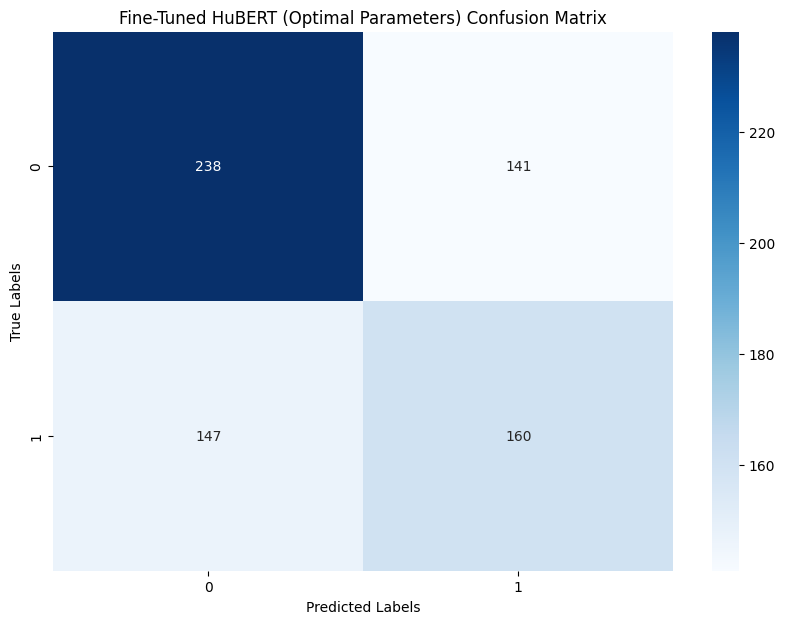

In [79]:
# Set the size of the figure
plt.figure(figsize=(10, 7))

# Create a heatmap from the confusion matrix
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=True)

# Set titles and labels
plt.title('Fine-Tuned HuBERT (Optimal Parameters) Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()